In [1]:
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
import re
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.read.option("header", "true").csv("data/cat_csv/*.csv")
df.count()

2805212

## Features

In [2]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price: string (nullable = true)
 |-- from: string (nullable = true)
 |-- to: string (nullable = true)
 |-- vendor: string (nullable = true)
 |-- cat_hash: string (nullable = true)
 |-- cat: string (nullable = true)
 |-- date: string (nullable = true)



## Clean the data

In [3]:
def processCountries(country):
    # Remove html tags
    cleanr = re.compile('<.*?>')
    cleanText = str(re.sub(cleanr, '', str(country)))
    
    # Remove spaces
    cleanText = cleanText.strip(' ')
    
    # Remove ""
    cleanText = cleanText.strip('"')
    
    # Split for each country
    cleanText = re.split("&|,|/", cleanText)
    
    return cleanText

udf_func_C = udf(processCountries, ArrayType(StringType()))

def processCatHashs(cat_hash):
    # Remove html end of files
    cleanr = re.compile('.\d*.html')
    cleanText = str(re.sub(cleanr, '', str(cat_hash)))
    return cleanText

udf_func_H = udf(processCatHashs, StringType())

In [4]:
# Remove rows without a valid date, error during parsing, file not complete
df = df.filter(df["date"].rlike("\d\d\d\d-\d\d-\d\d"))

# Remove rows without a price or not decimal, 642 in total, mainly due to error during parsing.
df = df.filter("CAST(price AS DECIMAL) is not null")

# Remove the rows where name is null, all the columns are usually null in this case, (6 rows)
df = df.filter("name is not null")

# Lowercase and process the countries
df=df.withColumn("to", lower(col("to")))
df=df.withColumn("to", udf_func_C(col("to")))

# Lowercase and process the countries
df=df.withColumn("from", lower(col("from")))
df=df.withColumn("from", udf_func_C(col("from")))

# Process the hashs
df=df.withColumn("cat_hash", udf_func_H(col("cat_hash")))

In [5]:
df.show(500)

+---+--------------------+-------------+-----------+--------------------+--------------------+----------+--------------------+----------+
|_c0|                name|        price|       from|                  to|              vendor|  cat_hash|                 cat|      date|
+---+--------------------+-------------+-----------+--------------------+--------------------+----------+--------------------+----------+
|  0|Jack Herer from S...|   0.73044494|      [usa]|              [None]|          MrSunshine|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  1|WHITE WIDOW FEMIN...|   3.31830703|       [eu]|              [None]|         klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  2|WHITE WIDOW FEMIN...|   0.85149010|       [eu]|              [None]|         klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  3|SMART START - See...|   0.07091576|       [eu]|              [None]|         klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  4|Marijuana Grow Ba...|   0.005

In [6]:
#test.groupby("from").agg(count("date")).show(321)

In [10]:
#test.filter("price like \[a-z\]").count()
#test.filter(test["from"].rlike("<imgclass=""flag*")).count()
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
#test.select(test.price.cast("float")).filter(test["price"].rlike("[a-zA-Z]")).count()
#df.filter("vendor is null").show()

+---+----+-----+----+---+------+--------+---+----+
|_c0|name|price|from| to|vendor|cat_hash|cat|date|
+---+----+-----+----+---+------+--------+---+----+
|  0|   0|    0|   0|  0|    11|       0|  0|   0|
+---+----+-----+----+---+------+--------+---+----+



In [11]:
import matplotlib.pyplot as plt
import pandas as pd
pdDF = df.groupby("date").agg(count("date")).toPandas()
ax = pdDF.plot.bar(rot=45)

date           201
count(date)    201
dtype: int64


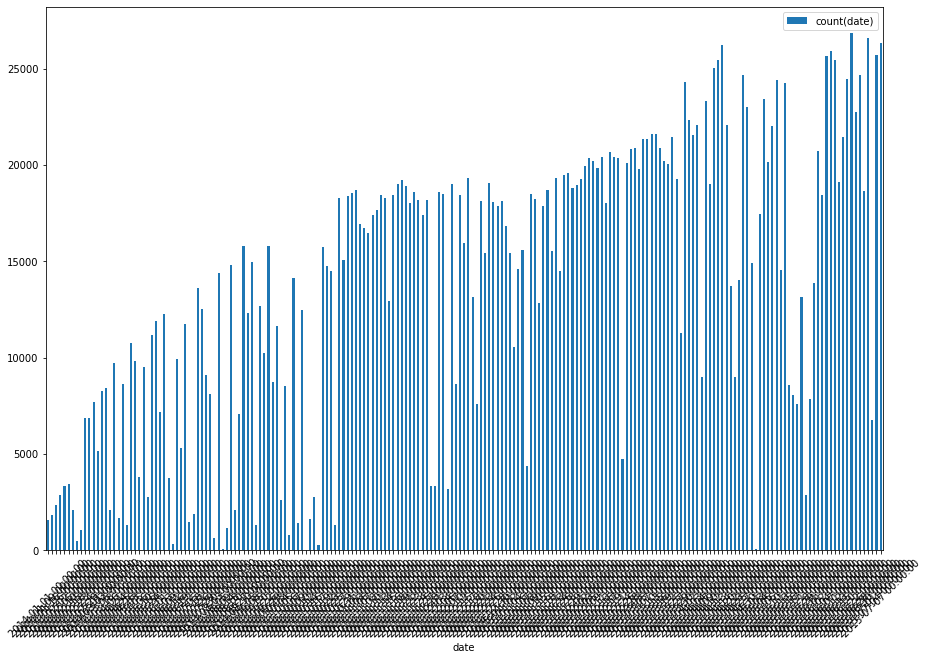

In [12]:

pdDF = pdDF[pdDF['date'].str.contains("\d\d\d\d-\d\d-\d\d")]
pdDF['date'] = pd.to_datetime(pdDF['date'],infer_datetime_format=True) 
pdDF = pdDF.sort_values(by='date', ascending=True, na_position='first')
print(pdDF.count())
pdDF.plot.bar(rot=45, figsize=(15,10), x='date', y='count(date)')

TypeError: the dtypes of parameters x (float64) and width (<U2) are incompatible

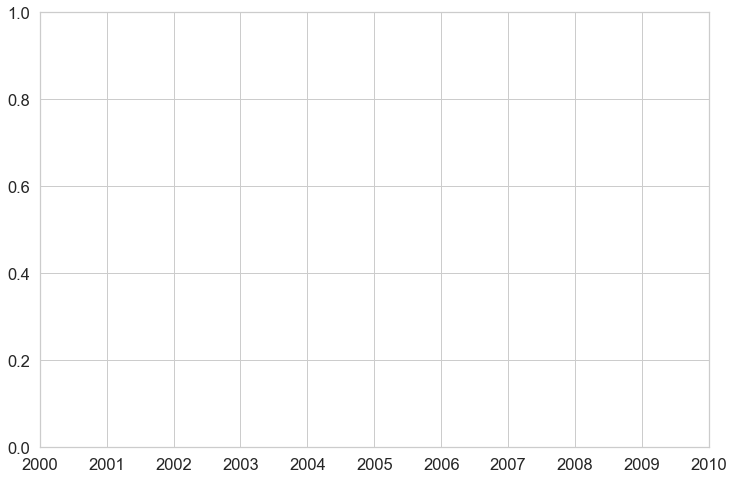

In [20]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(pdDF['date'],
        pdDF['count(date)'],
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="# of products",
       title="Number of products per day")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.show()

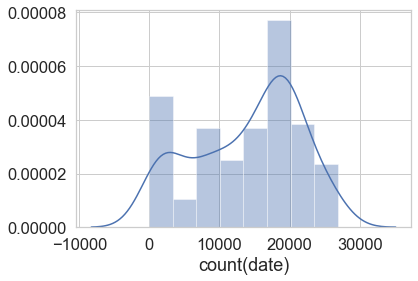

In [19]:
sns.distplot(pdDF['count(date)'])

In [14]:
test = df.groupby("date", "cat_hash").agg(count("cat_hash")).groupby("date").agg(count("cat_hash")).toPandas()
test = test[test['date'].str.contains("\d\d\d\d-\d\d-\d\d")]
test['date'] = pd.to_datetime(test['date'],infer_datetime_format=True) 
test = test.sort_values(by='date', ascending=True, na_position='first')
test.head()

,date,count(cat_hash)
91,2014-01-01,40
16,2014-01-09,44
112,2014-01-16,43
109,2014-01-26,51
179,2014-02-02,53


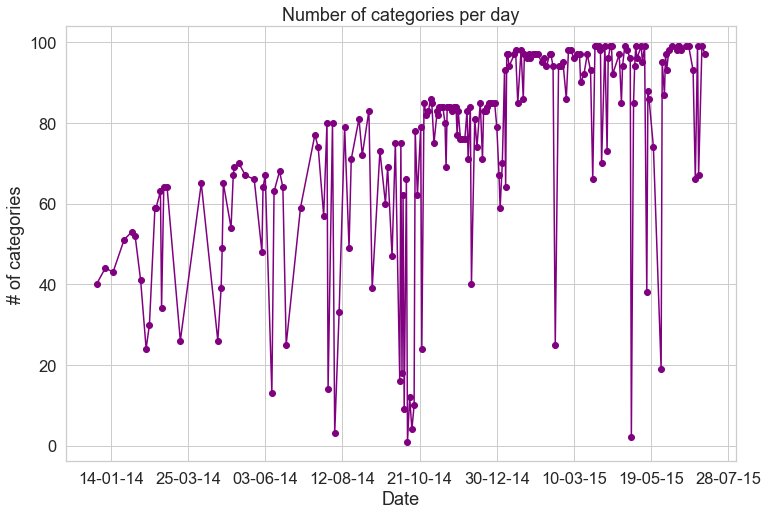

In [15]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test['date'],
        test['count(cat_hash)'],
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="# of categories",
       title="Number of categories per day")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.show()

In [16]:




test = test.rename(columns={'count(cat_hash)': 'catNumber'})

g = test.groupby([test.date.dt.month, test.date.dt.year]).max()

#test

IndexError: tuple index out of range

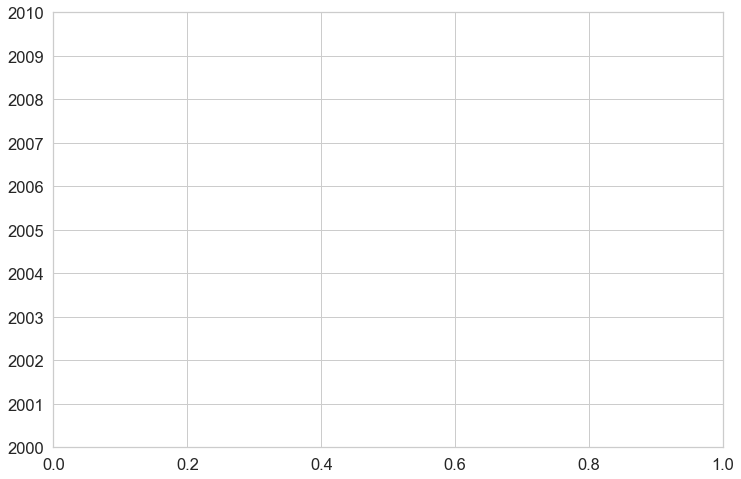

In [17]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(g.index,
        g,
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="# of categories",
       title="Number of categories per day")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.show()

In [ ]:
pdDF2 = pdDF.set_index('date')
#pdDF2
pdDF2 = pdDF2.loc[g['date'].values]
pdDF2.sort_index(inplace=True)
pdDF2

In [ ]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pdDF2.index,
        pdDF2,
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="# of categories",
       title="Number of categories per day")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.show()